# Wishart process regression

In [1]:
%load_ext autoreload
%autoreload 2

import os

SELECTED_DEVICE = '6'
print(f'Setting CUDA visible devices to [{SELECTED_DEVICE}]')
os.environ['CUDA_VISIBLE_DEVICES'] = f'{SELECTED_DEVICE}'

Setting CUDA visible devices to [6]


In [2]:
import matplotlib.pyplot as plt

import jax
jax.config.update("jax_enable_x64", True)

import jax.random as jrnd
import jax.numpy as jnp
import distrax as dx
import blackjax

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

import os
import sys

from blackjax import normal_random_walk
from blackjax.diagnostics import potential_scale_reduction, effective_sample_size

from jaxtyping import Array

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../../')))

from bamojax.base import Node, Model
from bamojax.sampling import gibbs_sampler, smc_inference_loop, elliptical_slice_nd

from bamojax.more_distributions import GaussianProcessFactory, RBF, Zero

print('Python version:       ', sys.version)
print('Jax version:          ', jax.__version__)
print('BlackJax version:     ', blackjax.__version__)
print('Distrax version:      ', dx.__version__)
print('Jax default backend:  ', jax.default_backend())
print('Jax devices:          ', jax.devices())

Python version:        3.10.15 (main, Oct  3 2024, 07:27:34) [GCC 11.2.0]
Jax version:           0.4.35
BlackJax version:      1.2.4
Distrax version:       0.1.5
Jax default backend:   gpu
Jax devices:           [CudaDevice(id=0)]


BaMoJax imports:

## The Wishart process

A much more complicated model, which requires a more elaborate link function. Generally, we have

\begin{align*}
    \theta &\sim \pi(\theta) &&\\
    f_{ij} &\sim \mathcal{GP}(0, \kappa_\theta) && i=1, \ldots, \nu,\quad j=1, \ldots, D\\
    L_m & \sim \mathcal{N}(0, 1) && m=1,\ldots, M\\
    \mathbf{f}_i(x_n) & = \left(f_{i1}(x_n), \ldots, f_{iD}(x_n)\right)^\top && i=1, \ldots, \nu, \quad n=1, \ldots, N\\
    \Sigma(x_n) &= \sum_{i=1}^{\nu} \mathbf{L} \mathbf{f}_i(x_n) \mathbf{f}_i(x_n)^\top \mathbf{L}^\top \sim \mathcal{W}\left(\nu, \mathbf{LL}^\top\right) && n=1, \ldots, N\\
    \mathbf{y}_n &\sim \mathcal{MVN}\left(\mathbf{\mu}, \Sigma(x_n)\right) && n=1, \ldots, N \enspace,
\end{align*} 

where $n=1, \ldots, N$, with $N$ the total number of observations, $\nu \geq D$ the degrees-of-freedom of the Wishart distribution, $M = D(D+1)/2$, and lastly $\kappa_\theta$ the GP covariance function with parameters $\theta$.

In [3]:
def wishart_transformation(F: Array, L: Array = None, L_vec = None) -> Array:
    r""" Transformes an array of (d, nu, n) Gaussian process draws into an array of (n, d, d) Wishart-distributed covariance matrices.

    Formally, we have

    \Sigma(t) = \sum_{j=1}^\nu L F(t)_j F(t)^T_j L^T.

    It follows from the construction (with GP output variance 1.0) that \Sigma(t) ~ W_d(V, nu), with V the Wishart location and nu its degrees of freedom.

    Args:
        F: An array of size (d, nu, n), with d the number of variables, nu>d the degrees-of-freedom and n the number of timepoints. F[i,j,:] ~ GP(mean, cov_fn)
        L: The Cholesky decomposition of the Wishart location matrix V
        L_vec: The transformed matrix vec(L) for easier sampling.
    Returns:
        LFFL: An array of size (n, d, d)

    """

    d = F.shape[0]
    F = jnp.transpose(F, axes=[2, 1, 0])

    def vec2tril(v):
        L_sample = jnp.zeros((d, d))
        return L_sample.at[jnp.tril_indices(d, 0)].set(v)

    #
    def outer_self_sum(x):
        def outer_self(x_):
            return jnp.outer(x_, x_)
        return jnp.sum(jax.vmap(outer_self, in_axes=(0))(x), axis=0)

    #
    if L is None and L_vec is not None:
        L = vec2tril(L_vec)

    FF = jax.vmap(outer_self_sum, in_axes=(0))(F)
    
    LFFL = jax.vmap(jnp.matmul,
                    in_axes=(0, None))(jax.vmap(jnp.matmul,
                                                in_axes=(None, 0))(L, FF), L.T)
    
    return LFFL
 
#
def wishart_link_fn(F: Array, shape: tuple, L: Array = None, L_vec: Array = None) -> dict:
    r""" Transform the (F, L) or (F, vec(L)) representation of the Wishart process into a set of parameters for dx.MultivariateNormalFullCovariance ('loc and covariance_matrix')

    Args:
        F: The (d, nu) draws of a GP, f ~ GP(., .). If the collected f's are flattened, they are reshaped here.
        L / vec(L): The scale matrix of the Wishart distribution.
    Returns:
        A dictionary containing the arguments for a distrax MultivariateNormalFullCovariance distribution object.    
    
    """
    if jnp.ndim(F) < 3:
        F = jnp.reshape(F, shape=shape)
    d = shape[0]
    LFFL = wishart_transformation(F=F, L=L, L_vec=L_vec)
    return dict(loc=jnp.zeros((d, )), covariance_matrix=LFFL)

#

Download timeseries for GWP example:

In [4]:
import numpy as np
import yfinance as yf

print('Download timeseries')
data = yf.download("^GDAXI ^GSPC", start="2017-09-10", end="2022-09-10", interval="1d")

close = data["Close"]
returns = np.log(close).diff().dropna()

Y = jnp.asarray(returns.iloc[0:-1:10, :])
time = returns.index[0:-1:10]

Download timeseries


[*********************100%***********************]  2 of 2 completed


Create BaMoJax Generalized Wishart Process (GWP).

Note: depending on the number of mutation steps within SMC, inference can take a while (12 min).

In [5]:
n, d = Y.shape
nu = d + 1
m = int(d*(d+1)/2)
x = jnp.linspace(0, 1, n)[:, jnp.newaxis]

partial_wishart_link_fn = lambda F, L_vec: wishart_link_fn(F=F, L_vec=L_vec, shape=(d, nu, n))

GWP = Model('Generalized Wishart process')
lengthscale = GWP.add_node(name='lengthscale', distribution=dx.Transformed(dx.Normal(loc=0., scale=1.), tfb.Exp()))
x_node = GWP.add_node(name='input', observations=x)
F = GWP.add_node(name='F', distribution=GaussianProcessFactory(mean_fn=Zero(), cov_fn=RBF()), 
                       parents=dict(input=x_node, 
                                    lengthscale=lengthscale, 
                                    variance=1.0), shape=(d, nu))
Lvec = GWP.add_node(name='L_vec', distribution=dx.Normal(loc=jnp.zeros((m, )), scale=jnp.ones((m, ))))
y_node = GWP.add_node(name='Y', distribution=dx.MultivariateNormalFullCovariance, parents=dict(F=F, L_vec=Lvec), link_fn=partial_wishart_link_fn, observations=Y)

Set up Gibbs sampling within SMC for GWP (takes roughly 20 minutes):

In [6]:
%%time

from bamojax.sampling import elliptical_slice_nd

step_fns = dict(lengthscale=normal_random_walk,
                L_vec=normal_random_walk,
                F=elliptical_slice_nd)
step_fn_params = dict(lengthscale=dict(sigma=0.01),
                      L_vec=dict(sigma=0.001*jnp.eye(m)),  # Note the tiny stepsize; should we just a different prior on the elements too?
                      F=dict(implied_mvn_prior=True, name='elliptical_slice_nd', nd=(d, nu)))

gibbs = gibbs_sampler(GWP, step_fns=step_fns, step_fn_params=step_fn_params)

key = jrnd.PRNGKey(1234)
key, subkey = jrnd.split(key)
final_state, lml, n_iter, final_info = smc_inference_loop(subkey, GWP, kernel=gibbs, num_particles=1000, num_mcmc_steps=500)

for node in ['lengthscale', 'L_vec']:
    print(f'Acceptance rate for {node}: {jnp.mean(final_info.update_info[node].is_accepted):0.3f}')

Acceptance rate for lengthscale: 0.020
Acceptance rate for L_vec: 0.084
CPU times: user 20min 18s, sys: 3.29 s, total: 20min 22s
Wall time: 20min 38s


Visualize model fit:

Text(0.5, 0, 'Lengthscale (weeks)')

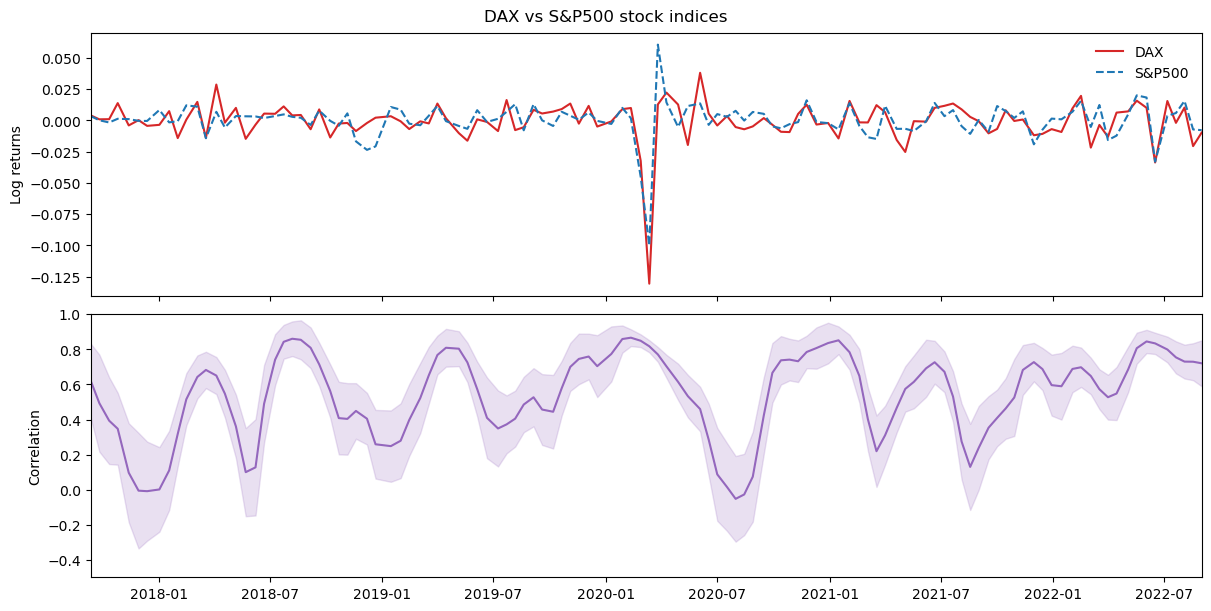

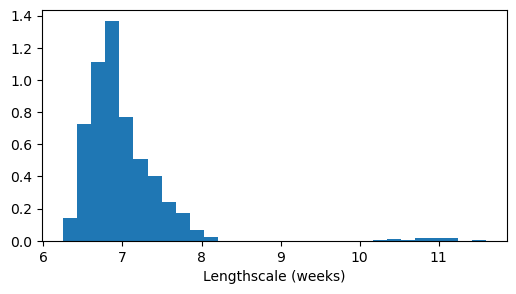

In [7]:
def cov2corr(Sigma):
    v = jnp.sqrt(jnp.diag(Sigma))
    outer_v = jnp.outer(v, v)
    correlation = Sigma / outer_v
    return correlation

#

wrapper = lambda F, Lvec: wishart_transformation(F=F, L_vec=Lvec)
LFFL_samples = jax.vmap(wrapper, in_axes=(0, 0))(final_state.particles['F'], final_state.particles['L_vec'])
corr_samples = jax.vmap(jax.vmap(cov2corr, in_axes=0), in_axes=0)(LFFL_samples)

corr_mean = jnp.mean(corr_samples, axis=0)
corr_std = jnp.std(corr_samples, axis=0)

_, axes = plt.subplots(nrows=2, ncols=1, sharex=True, constrained_layout=True, figsize=(12, 6))
axes[0].plot(time, Y[:,0], label='DAX', color='tab:red')
axes[0].plot(time, Y[:,1], label='S&P500', color='tab:blue', ls='--')
axes[0].legend(frameon=False)
axes[0].set_ylabel('Log returns')
axes[1].plot(time, corr_mean[:, 0, 1], color='tab:purple')
axes[1].fill_between(time, corr_mean[:, 0, 1] - 0.5*corr_std[:, 0, 1], corr_mean[:, 0, 1] + 0.5*corr_std[:, 0, 1], color='tab:purple', alpha=0.2)
axes[1].set_ylabel('Correlation')
axes[1].set_ylim([-0.5, 1.0])
for ax in axes:
    ax.set_xlim([time[0], time[-1]])
plt.suptitle('DAX vs S&P500 stock indices');

plt.figure(figsize=(6, 3))
plt.hist(final_state.particles['lengthscale']*(time[-1] - time[0]).days/7, bins=30, density=True);  # converted to years
plt.xlabel('Lengthscale (weeks)')

[TODO] Add a Gibbs run first to determine appropriate step sizes for $\ell$ (does not seem nicely converged) and the elements of $L$.

[TODO] Add sliding window for comparison.

Another GWP example, but with a known ground truth. The setup is a bit clunky.

Gibbs structure:
lengthscale         : p(F | variance_F, input, lengthscale) p(lengthscale)
F                   : p(Y | F, L_vec) p(F | lengthscale, variance_F, input)
L_vec               : p(Y | L_vec, F) p(L_vec)
Acceptance rate for lengthscale: 0.222
Acceptance rate for L_vec: 0.439


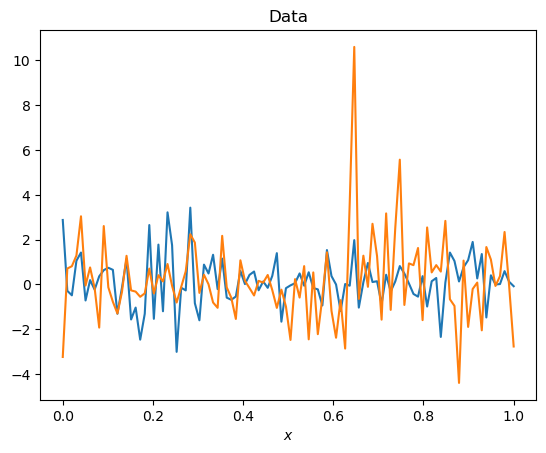

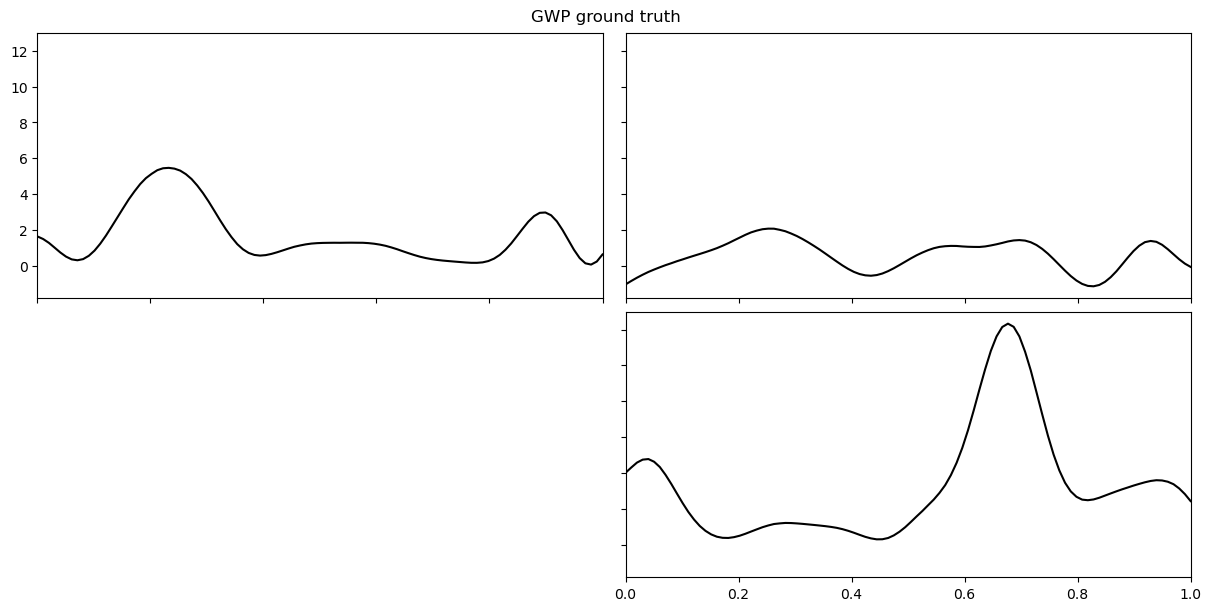

In [8]:
key = jrnd.PRNGKey(42)

n = 100
d = 2
nu = d+1
m = int(d * (d + 1) / 2)  # include diagonal!
x = jnp.linspace(0, 1, num=n)[:, jnp.newaxis]
L = jnp.linalg.cholesky(jnp.eye(d))  # for completeness; this is just an identity again

GWP_prior = Model('Generalized Wishart process')
lengthscale = GWP_prior.add_node(name='lengthscale', observations=0.1)
x_node = GWP_prior.add_node(name='input', observations=x)
F = GWP_prior.add_node(name='F', distribution=GaussianProcessFactory(mean_fn=Zero(), cov_fn=RBF()), 
                       parents=dict(input=x_node, 
                                    lengthscale=lengthscale, 
                                    variance=1.0), shape=(d, nu))
Lvec = GWP_prior.add_node(name='L_vec', observations=L[jnp.triu_indices(n=d, k=0)])
y_node = GWP_prior.add_node(name='Y', distribution=dx.MultivariateNormalFullCovariance, parents=dict(F=F, L_vec=Lvec), link_fn=partial_wishart_link_fn, observations=[])

key, subkey = jrnd.split(key)
sample = GWP_prior.sample_prior_predictive(subkey)
Y = sample['Y']

GWP = Model('Generalized Wishart process')
lengthscale = GWP.add_node(name='lengthscale', distribution=dx.Transformed(dx.Normal(loc=-1., scale=1.), tfb.Exp()))
x_node = GWP.add_node(name='input', observations=x)
F = GWP.add_node(name='F', distribution=GaussianProcessFactory(mean_fn=Zero(), cov_fn=RBF()), 
                       parents=dict(input=x_node, 
                                    lengthscale=lengthscale, 
                                    variance=1.0), shape=(d, nu))
L = jnp.eye(d)
Lvec_obs = L[jnp.triu_indices_from(L)]
Lvec = GWP.add_node(name='L_vec', distribution=dx.Normal(loc=jnp.zeros((m, )), scale=jnp.ones((m, ))))
y_node = GWP.add_node(name='Y', distribution=dx.MultivariateNormalFullCovariance, parents=dict(F=F, L_vec=Lvec), link_fn=partial_wishart_link_fn, observations=Y)

GWP.print_gibbs()

F_gt = sample['F']
L_gt = GWP_prior.nodes['L_vec'].observations
ell_gt = GWP_prior.nodes['lengthscale'].observations
LFFL_gt = wishart_transformation(F=F_gt, L_vec=L_gt)

plt.figure()
plt.plot(x, Y)
plt.xlabel(r'$x$')
plt.title('Data')

_, axes = plt.subplots(nrows=d, ncols=d, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
for i in range(d):
    for j in range(i, d):
        axes[i,j].plot(x, LFFL_gt[:, i, j], color='k')
        axes[i,j].set_xlim([0, 1])   
axes[1,0].axis('off')
plt.suptitle('GWP ground truth')

step_fns = dict(lengthscale=normal_random_walk,
                L_vec=normal_random_walk,
                F=elliptical_slice_nd)
step_fn_params = dict(lengthscale=dict(sigma=0.005),
                      L_vec=dict(sigma=0.03*jnp.eye(m)),
                      F=dict(implied_mvn_prior=True, name='elliptical_slice_nd', nd=(d, nu)))

gibbs = gibbs_sampler(GWP, step_fns=step_fns, step_fn_params=step_fn_params)

key, subkey = jrnd.split(key)
final_state, lml, n_iter, final_info = smc_inference_loop(subkey, GWP, kernel=gibbs, num_particles=1000, num_mcmc_steps=300)

for node in ['lengthscale', 'L_vec']:
    print(f'Acceptance rate for {node}: {jnp.mean(final_info.update_info[node].is_accepted):0.3f}')

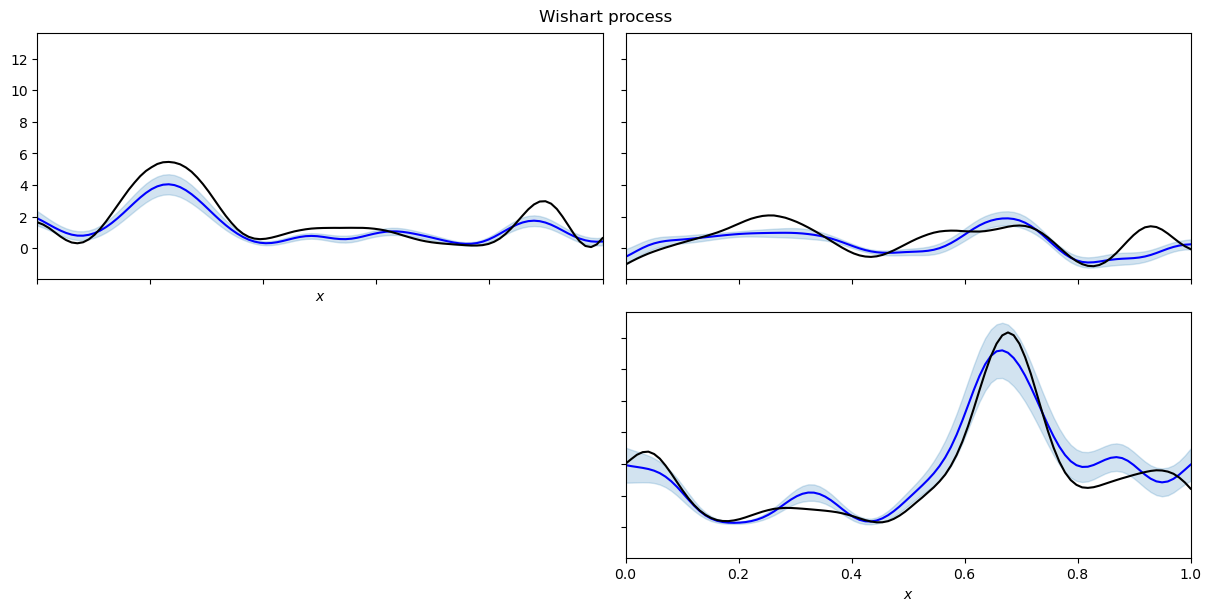

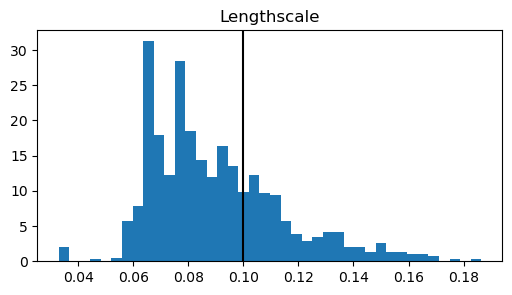

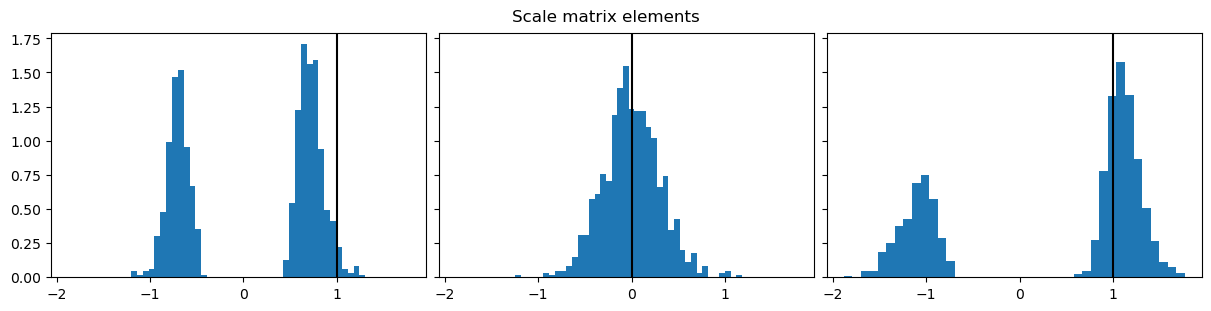

In [9]:
# We need a wrapper because we cannot pass keyword-arguments in a vmap
wrapper = lambda F, Lvec: wishart_transformation(F=F, L_vec=Lvec)
LFFL_samples = jax.vmap(wrapper, in_axes=(0, 0))(final_state.particles['F'], final_state.particles['L_vec'])

LFFL_mean = jnp.mean(LFFL_samples, axis=0)
LFFL_std = jnp.std(LFFL_samples, axis=0)

_, axes = plt.subplots(nrows=d, ncols=d, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
for i in range(d):
    for j in range(i, d):
        axes[i,j].plot(x, LFFL_mean[:, i, j], color='b')
        axes[i,j].fill_between(x.flatten(), LFFL_mean[:, i, j] - 0.5*LFFL_std[:, i, j], LFFL_mean[:, i, j] + 0.5*LFFL_std[:, i, j], color='tab:blue', alpha=0.2)
        axes[i,j].plot(x, LFFL_gt[:, i, j], color='k')
        axes[i,j].set_xlim([0, 1])
    axes[i,i].set_xlabel(r'$x$')
axes[1, 0].axis('off')
plt.suptitle('Wishart process')


plt.figure(figsize=(6, 3))
ax = plt.gca()
ax.hist(final_state.particles['lengthscale'], facecolor='tab:blue', bins=40, density=True)
ax.axvline(x=ell_gt, color='k')
ax.set_title('Lengthscale')

_, axes = plt.subplots(nrows=1, ncols=m, sharex=True, sharey=True, constrained_layout=True, figsize=(12, 3))
for i in range(m):
    axes[i].hist(final_state.particles['L_vec'][:, i], facecolor='tab:blue', bins=40, density=True)
    axes[i].axvline(x=L_gt[i], color='k')
plt.suptitle('Scale matrix elements');

In this run, we happen to see the multimodality in the scaling matrix. This follows from $V = LL^\top$, so the sign of $L$ is not identifiable.

In [10]:
L = -1*jnp.eye(2)
V = jnp.dot(L, L.T)
print(V)

[[1. 0.]
 [0. 1.]]
